# Data assimilation using PCA

## Modules

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

from joblib import load
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

# Observation data

In [2]:
#Loading observation/satellite images

obs_data = np.load("Data/Ferguson_fire_obs.npy")
print("Data type of observation array: ", obs_data.dtype)
print("Shape of observation data: ", obs_data.shape)
print("Unique pixel values in observation data: ", np.unique(obs_data))

Data type of observation array:  float64
Shape of observation data:  (5, 256, 256)
Unique pixel values in observation data:  [0. 1.]


### Original observation images

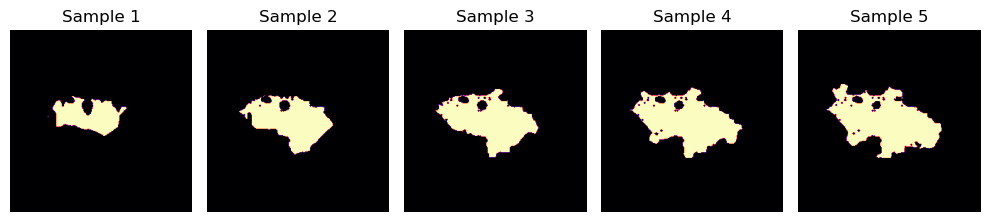

In [3]:
#Visualising all the images in the observation dataset

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 8))
axes = axes.ravel() 
for i in range(5):
    axes[i].imshow(obs_data[i], cmap='magma') 
    axes[i].set_title(f"Sample {i+1}") 
    axes[i].set_axis_off()
plt.tight_layout()
plt.show()

### Reshaping observation data

In [4]:
#Flattening individual images for PCA 

obs_reshaped = np.reshape(obs_data, (obs_data.shape[0], obs_data.shape[1]*obs_data.shape[2]))
print(f"After reshaping: {obs_reshaped.shape}")

After reshaping: (5, 65536)


# Background data

In [5]:
#Loading background/simulated images

background_data = np.load("Data/Ferguson_fire_background.npy")
print("Data type of background array: ", background_data.dtype)
print("Shape of background data: ", background_data.shape)
print("Unique pixel values in background data: ", np.unique(background_data))

Data type of background array:  int16
Shape of background data:  (5, 256, 256)
Unique pixel values in background data:  [0 1]


### Original background images 

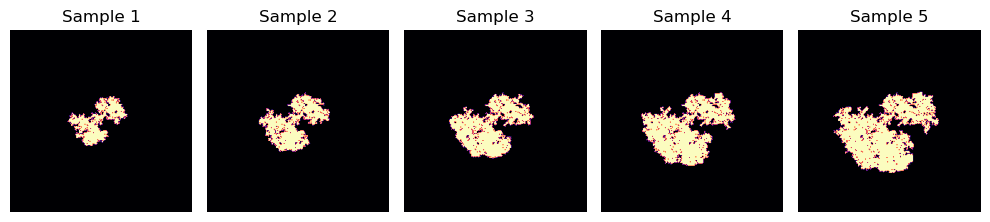

In [6]:
#Visualising all the images in background dataset

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 8))
axes = axes.ravel() 
for i in range(5):
    axes[i].imshow(background_data[i], cmap='magma') 
    axes[i].set_title(f"Sample {i+1}") 
    axes[i].set_axis_off()
plt.tight_layout()
plt.show()

### Reshaping background images

In [7]:
#Flatteniing individual images for PCA

background_reshaped = np.reshape(background_data, (background_data.shape[0], background_data.shape[1]*background_data.shape[2]))
print(f"After reshaping: {background_reshaped.shape}")

After reshaping: (5, 65536)


### Loading the PCA model generated in Dimensionality reduction.

#### OneDrive link to the models for PCA and Autoencoder

[Models](https://imperiallondon-my.sharepoint.com/:f:/r/personal/gmn22_ic_ac_uk/Documents/models_bda?csf=1&web=1&e=BAVPVz)

In [8]:
# Loading model using joblib load

pca_loaded = load('pca_model.joblib')

In [9]:
#Trucation parameter Previously used in Q1 
k = 100 

### Compressing observation and background data 

In [10]:
#Compressing using PCA model previously developed

obs_compressed = pca_loaded.transform(obs_reshaped)
background_compressed = pca_loaded.transform(background_reshaped)

### Data assimilation using Kalman Filter (BLUE)

### Defining functions 

In [11]:
from numpy.linalg import inv

def update_prediction(x, K, H, y):
    res = x + np.dot(K,(y - np.dot(H, x)))
    return res  

def KalmanGain(B, H, R):
    tempInv = inv(R + np.dot(H,np.dot(B,H.transpose())))
    res = np.dot(B,np.dot(H.transpose(),tempInv))
    return res

### Define functions for calculating the parameters for Kalman Filter

In [12]:
nNodes = k #principal components/ truncation parameter k
I = np.identity(nNodes)
R = I*0.001
H = I #Observation operator
B = np.cov(background_compressed.T)

### Run data assimilation

In [13]:
start = time.time()

K = KalmanGain(B, H, R) 
updated_da_list = []
#Looping over every image in background dataset
for i in range(len(background_compressed)):
    #Updating the prediction for each pixel in background
    updated_da = update_prediction(background_compressed[i], K, H, obs_compressed[i]) #compute only the analysis
    #Adding it to a new assimilated array
    updated_da_list.append(updated_da)
updated_da_array = np.array(updated_da_list)
end = time.time()

### Reconstruction assimilated data from latent space

In [14]:
#Reconstructing/decompressing images from latent space

da_data = pca_loaded.inverse_transform(updated_da_array)

### Reconstructed images vs original images

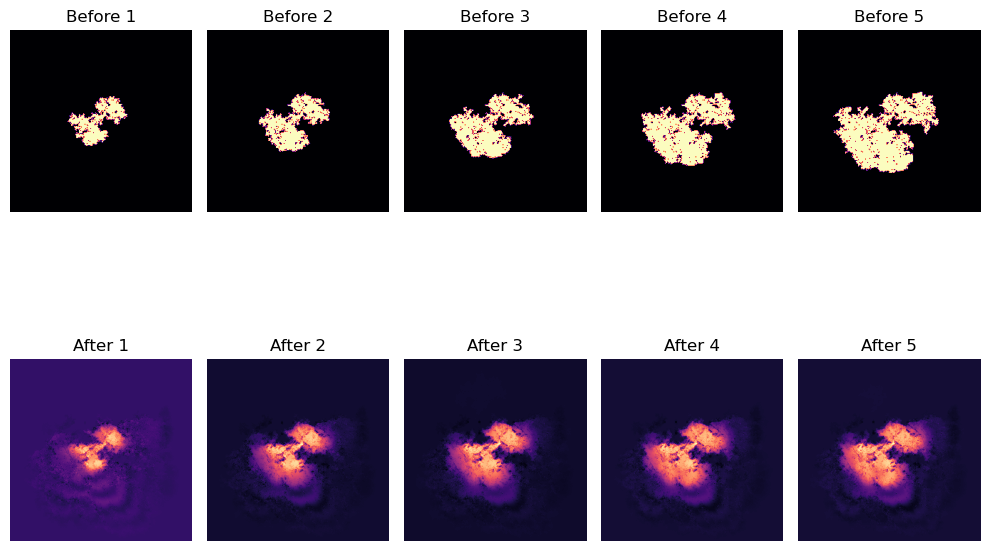

In [15]:
#Visualising reconstructed images

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 8))
axes = axes.ravel() 
for i in range(5):
    axes[i].imshow(background_data[i], cmap='magma') 
    axes[i].set_title(f"Before {i+1}") 
    axes[i].set_axis_off()
    
    axes[i+5].imshow(da_data[i].reshape(256, 256), cmap='magma') 
    axes[i+5].set_title(f"After {i+1}") 
    axes[i+5].set_axis_off()
plt.tight_layout()
plt.show()

### Calculating Mean Squared Error

In [16]:
time_taken = end - start

mse_before_da_physical = mean_squared_error(obs_reshaped, background_reshaped)
mse_after_da_physical = mean_squared_error(obs_reshaped, da_data)

mse_before_da_latent = mean_squared_error(obs_compressed, background_compressed)
mse_after_da_latent = mean_squared_error(obs_compressed, updated_da_array)

## Results

In [17]:
print("Time taken for assimilation: ", time_taken, "seconds")
print("MSE before DA in latent space: ", mse_before_da_latent)
print("MSE after DA in latent space: ", mse_after_da_latent)
print("MSE before DA in physical space: ", mse_before_da_physical)
print("MSE after DA in physical space: ", mse_after_da_physical)

Time taken for assimilation:  0.010998964309692383 seconds
MSE before DA in latent space:  18.669399543019942
MSE after DA in latent space:  12.70196050404507
MSE before DA in physical space:  0.0772430419921875
MSE after DA in physical space:  0.057310592761860096


### Optimum parameter search


In [18]:
def optim_params(x, y):
    nNodes = k #principal components/ truncation parameter k
    I = np.identity(nNodes)
    R = I*x
    H = I 
    B = np.cov(background_compressed.T)
    return B, H, R

x_values = [0.00001, .0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3]
y_values = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4]


def mse_diff(x, y):
    B, H, R = optim_params(x, y)
    K = KalmanGain(B, H, R)
    updated_da_list = []
    for i in range(len(background_compressed)):
        updated_da = update_prediction(background_compressed[i], K, H, obs_compressed[i]) #compute only the analysis
        updated_da_list.append(updated_da)
    updated_da_array = np.array(updated_da_list)

    da_data = pca_loaded.inverse_transform(updated_da_array)
    # For latent space MSE optimisation
#     mse_before_da_latent = mean_squared_error(obs_compressed, background_compressed)
#     mse_after_da_latent = mean_squared_error(obs_compressed, updated_da_array)
#     diff = mse_before_da_latent - mse_after_da_latent
    
# For physical space MSE optimisation
    mse_before_da_physical = mean_squared_error(obs_reshaped, background_reshaped)
    mse_after_da_physical = mean_squared_error(obs_reshaped, da_data)
    diff =  mse_before_da_physical - mse_after_da_physical
    return diff

def binary_search_maximize():
    best_diff = float('-inf')
    best_x = None
    best_y = None

    for x in x_values:
        for y in y_values:
            diff = mse_diff(x, y)
            if diff > best_diff:
                best_diff = diff
                best_x = x
                best_y = y

    return best_x, best_y


In [19]:
# Binary search for optimum values
best_x, best_y = binary_search_maximize()

print('Optimum x: ', best_x)
print('Optimum y: ', best_y)
print("MSE difference for optimum values: ", mse_diff(best_x, best_y))

Optimum x:  1e-05
Optimum y:  0.0001
MSE difference for optimum values:  0.01993244925014742


## Analysis:

- MSE error depends not only on PCA model but also on the values R(observation error variance) and B(control matrix) choosen for assimilation. Since, we don't know how much to rely on our observation data even though it is satellite imagery.
- Running a binary search on bigger domain of R and B to maximise the MSE after and MSE before difference can help to get the best values.

<b>Binary search for choosing the optimum parameters for KALMAN GAIN </b>
 - Optimising MSE in latent space with B= np.cov(background_compressed.T)
   - Optimum R:  I*1e-05
   - MSE difference for optimum values:  5.9674390519641225
 
 - Optimising MSE in physical space with B= np.cov(background_compressed.T)
   - Optimum R:  I*1e-05
   - MSE difference for optimum values:  0.01993244925014742
- Optimising MSE in latent space
  - Optimum R:  I*1e-05
  - Optimum B:  I*4
  - MSE difference for optimum values:  18.66939954290326

- Optimising MSE in physical space
   - Optimum R:  I*1e-05
   - Optimum B:  I*4
   - MSE difference for optimum values:  0.03931410283129231

<b>From the observations:</b> `As the coeff in R decreases`, difference between before and after `MSE is maximised`. The `R in this case is uncertainty or noise in satellite images`. So, we get `better results as we trust satellite images more`. This means `the satellite images are reliable`.  

<b>- Better results could have been achieved if we allowed PCA for higher variance with bigger truncation value(k)</b> 